In [1]:
import neat
import os
import evogym.envs
from evogym import is_connected, has_actuator, get_full_connectivity, hashable
import numpy as np
import dill
import pickle as pkl
import sys
sys.path.append('../')

from hyperneat.new_hyperNEAT import create_phenotype_network
from hyperneat.substrate import Substrate
from hyperneat.visualize import draw_net
from dynamic_env.traverser import DynamicObstacleTraverser


import itertools as it
import time
import imageio

from matplotlib import pyplot as plt


from sgr.substrates import morph_substrate, control_substrate
from sgr.generate_robot import generate_robot, eval_robot_constraint
from sgr.evogym_sim import simulate_env
from sgr.body_speciation import CustomGenome


In [2]:
def get_robot(genome, robot_size, neat_config):
    if genome.robot is not None:
        robot = genome.robot
    else:
        cppn = neat.nn.FeedForwardNetwork.create(genome, neat_config)
        design_substrate = morph_substrate(robot_size)
        design_net = create_phenotype_network(cppn, design_substrate)
        robot = generate_robot(design_net, robot_size)
        print(robot)

    if not eval_robot_constraint(robot):
        return robot, None
    connections = get_full_connectivity(robot)

    
    env = DynamicObstacleTraverser(body=robot, connections=connections, filename="../dynamic_env/env.json")
    img = env.render(mode='img')
    env.close()
    return robot, img

In [4]:
# STEPS = 400
# ROBOT_SIZE = 5
# POP = 48

# directory = "results/" + ENV

# params = {"robot_size": ROBOT_SIZE, "env": "dynamic", "steps": STEPS, "pop_size": POP}

# morphology_coords = morph_substrate(ROBOT_SIZE)
# CustomGenome.robot_func = lambda self, net, params: generate_robot(net, ROBOT_SIZE)
# CustomGenome.substrate = morphology_coords
# CustomGenome.robot_size = ROBOT_SIZE


# neat_config = neat.config.Config(
#     CustomGenome,
#     neat.reproduction.DefaultReproduction, 
#     neat.species.DefaultSpeciesSet, 
#     neat.stagnation.DefaultStagnation, 
#     "../configs/POET.cfg"
# )

# input_size = morphology_coords.dimensions*2 + 1 # two coordinates plus the bias
# neat_config.genome_config.num_inputs = input_size
# neat_config.genome_config.input_keys = [-1*i for i in range(1, input_size+1)]
# neat_config.genome_config.num_outputs = 1
# neat_config.genome_config.output_keys = [1]

with open(f"../poet/cp5_gen_325.pkl", "rb") as file:
    poet_pop = pkl.load(file)



###################### Pair (0, 243) ########################

14155 7.38676323141972


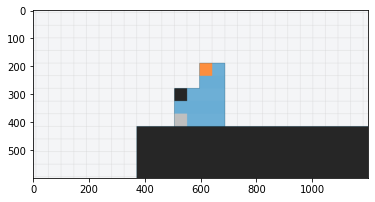

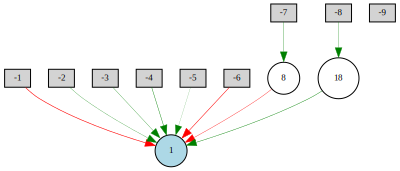

13375 7.383488505710041


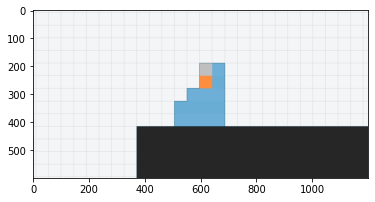

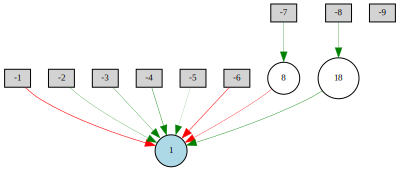



###################### Pair (1, 2) ########################

11649 7.379532469046626


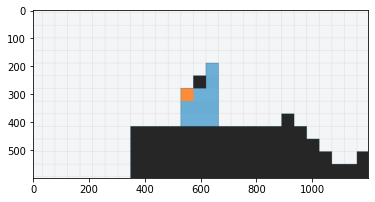

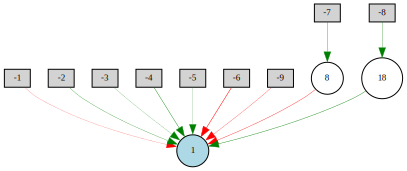

12928 7.379532469046626


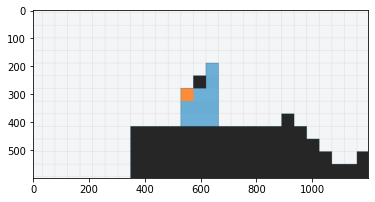

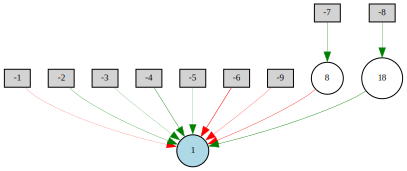



###################### Pair (2, 2) ########################

13954 4.9006157374865325


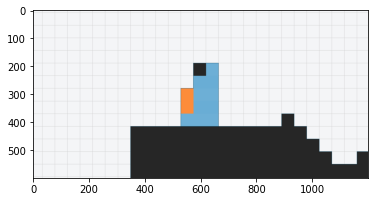

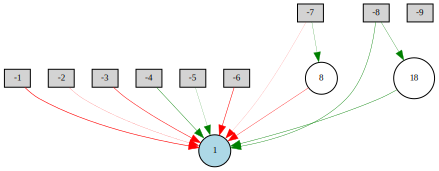

14046 4.646390036027645


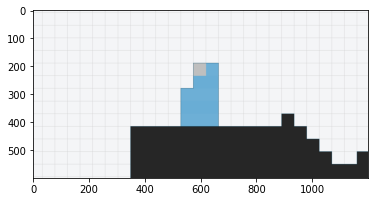

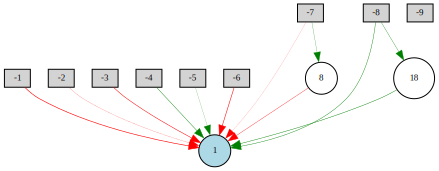

13573 7.428408119574816


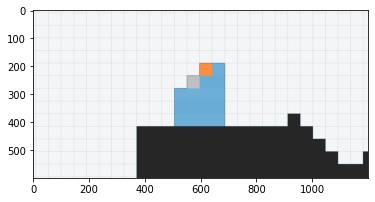

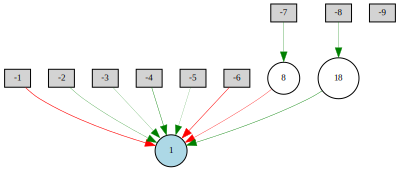

14071 7.428408119574816


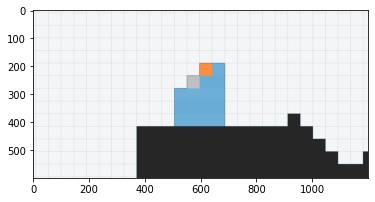

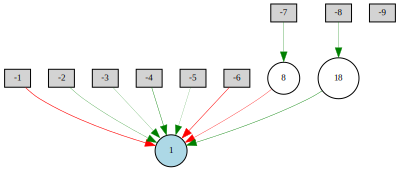



###################### Pair (11, 2) ########################

14085 7.255666241227652


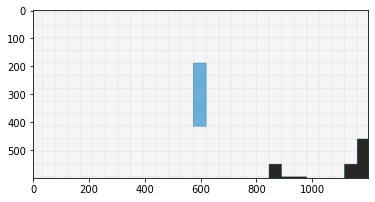

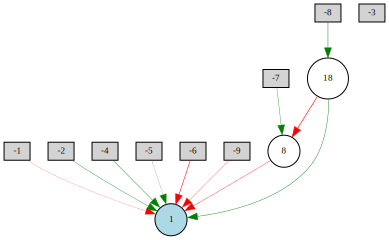

14100 7.255666241227652


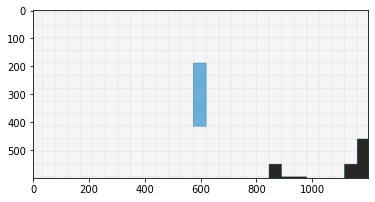

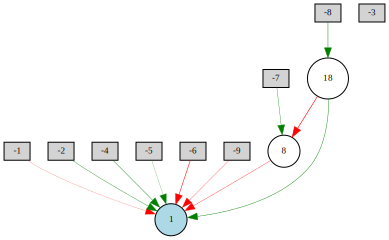



###################### Pair (12, 2) ########################

13994 7.438491547867312


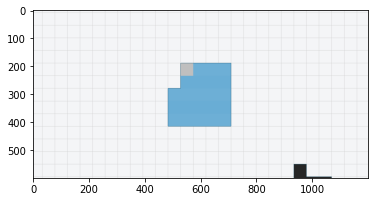

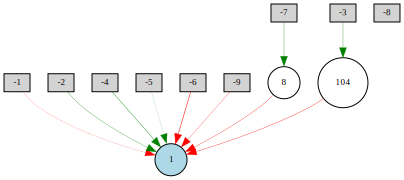

13936 7.43737711019158


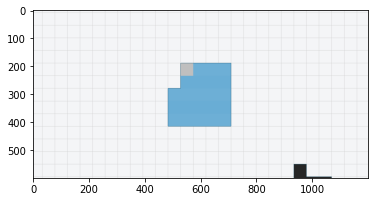

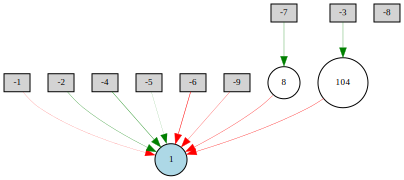



###################### Pair (26, 243) ########################



###################### Pair (28, 243) ########################



###################### Pair (36, 2) ########################



###################### Pair (31, 2) ########################



###################### Pair (50, 243) ########################

13986 7.304381515016935


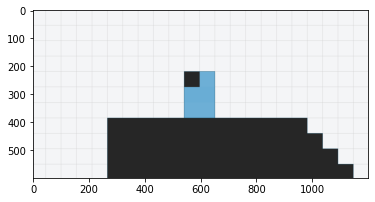

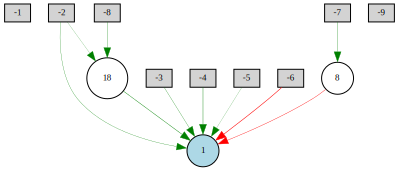

13989 7.302259197599666


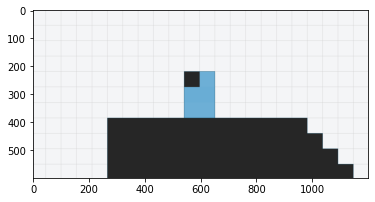

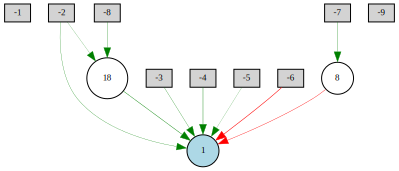

13913 7.436766069315918


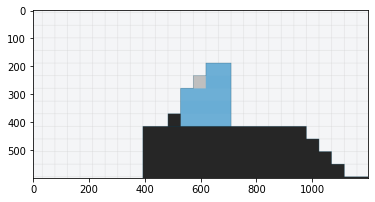

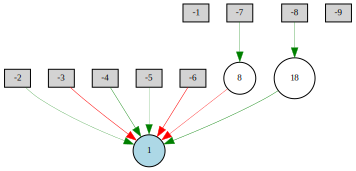

13870 7.430822796360455


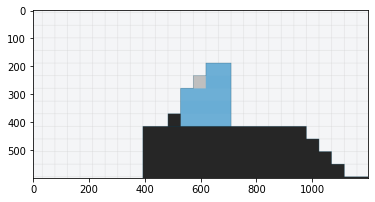

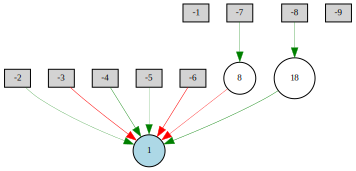



###################### Pair (43, 180) ########################



###################### Pair (51, 251) ########################



###################### Pair (54, 284) ########################

13063 3.3426756603712433


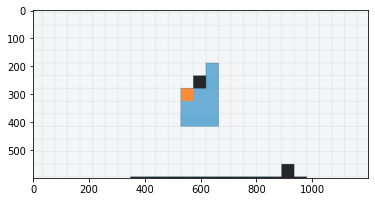

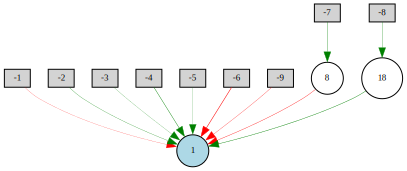

13953 3.3426756603712433


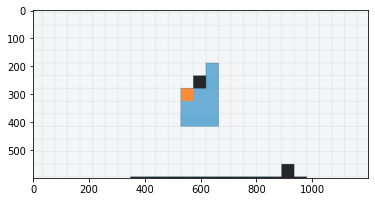

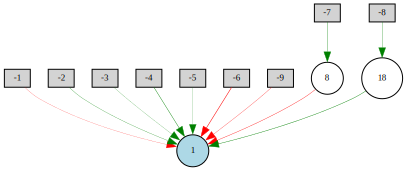

In [5]:
for p in poet_pop.pairs:
    pop = p.agent_pop
    env = p.environment
    print(f"\n\n###################### Pair ({env.id}, {pop.id}) ########################\n")
    env.generate_json("env.json")
    for ag_id, ag in pop.pop.population.items():
        if ag.fitness is not None and ag.fitness > 2:
            r, img = get_robot(ag, pop.robot_size, pop.neat_config)
            if img is not None:
                print(ag.key, ag.fitness)
                plt.imshow(img)
                plt.show()
                net = neat.nn.FeedForwardNetwork.create(ag, pop.neat_config)
                display(draw_net(net))

In [6]:
STEPS = 400
env_dict = {}
ag_dict = {}
for p in poet_pop.pairs:
    pop = p.agent_pop
    env = p.environment
    for ag_id, ag in pop.pop.population.items():
        ag_dict[ag_id] = (ag, pop)
    env_dict[env.id] = env



In [7]:
def show_exec(ag_id, env_id):
    env_dict[env_id].generate_json("env.json")
    ag, pop = ag_dict[ag_id]
    reward, done = pop.single_genome_fit(ag, STEPS, "dynamic", True, None)
    return reward, done

In [8]:
r, d = show_exec(6991, 0)
print(r)

KeyError: 6991

In [10]:
for k, v in env_dict.items():
    print(v.__dict__)

{'id': 0, 'seed': SeedSequence(
    entropy=121352725589048537982854257596012177648,
    spawn_key=(1,),
), 'rng': Generator(PCG64) at 0x7FDAA9322320, 'barrier_h': 0, 'heights_list': [0], 'obstacle_prob': array([1])}
{'id': 1, 'seed': SeedSequence(
    entropy=121352725589048537982854257596012177648,
    spawn_key=(1,),
), 'rng': Generator(PCG64) at 0x7FDAA8A1EE60, 'barrier_h': 1, 'heights_list': [-1, 0, 1], 'obstacle_prob': array([0.7 , 0.07, 0.23])}
{'id': 2, 'seed': SeedSequence(
    entropy=121352725589048537982854257596012177648,
    spawn_key=(1,),
), 'rng': Generator(PCG64) at 0x7FDAA80688C0, 'barrier_h': 1, 'heights_list': [-1, 0, 1], 'obstacle_prob': array([0.7 , 0.07, 0.23])}
{'id': 11, 'seed': SeedSequence(
    entropy=121352725589048537982854257596012177648,
    spawn_key=(1,),
), 'rng': Generator(PCG64) at 0x7FDAA7934410, 'barrier_h': 2, 'heights_list': [-2, -1, 0, 1, 2], 'obstacle_prob': array([0.01, 0.21, 0.28, 0.24, 0.26])}
{'id': 12, 'seed': SeedSequence(
    entropy=1